In [209]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [224]:
dog_org = Image.open("examples/dog.jpg")
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
 )])
dog = transform(dog_org)

In [225]:
import torch
import numpy as np
import torch.nn.functional as F
from functools import partial

image_batch = torch.unsqueeze(dog, 0)

def gaussian_kernel(size=5, channels=3, sigma=1):
    ax = np.linspace(-(size - 1)/ 2., (size-1)/2., size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx)+ np.square(yy)) / np.square(sigma))
    kernel /= np.sum(kernel)
    kernel_tensor = torch.as_tensor(kernel, dtype=torch.float)
    kernel_tensor = kernel_tensor.repeat(channels, 1 , 1, 1)
    return kernel_tensor

def get_gaussian_blur_conv(kernel):
    channels = kernel.shape[0]
    padding = kernel.shape[-1] // 2
    gaussian_blur = partial(F.conv2d, weight=kernel, stride=1, padding=padding, groups=channels)
    return gaussian_blur


class PyramidImageLayer(nn.Module):
    def __init__(self, gaussian_size=3, init_sigma=1.6, pyramid_depth=3):
        super().__init__()
        self.weight = nn.Parameter(torch.rand((3, 224, 224), requires_grad=True))
        self.org_shape = self.weight.shape
        self.current_pyramid_level = 0
        self.gaussian_size = gaussian_size
        self.init_sigma = init_sigma
        self.pyramid_depth = pyramid_depth
        self.gaussian_blur = self._get_gaussian_blur()
    
    @property
    def image_numpy(self):
        """Return image as a numpy array (channel-last)."""
        img = self.weight.data.detach().numpy()
        img = img.transpose(1, 2, 0)
        return img
    
    def _get_gaussian_blur(self):
        sigma = self.init_sigma * (2**self.current_pyramid_level)
        kernel = gaussian_kernel(size=self.gaussian_size, sigma=sigma)
        gaussian_blur = get_gaussian_blur_conv(kernel)
        return gaussian_blur
        
    def init_layer(self, image_batch):
        self.weight.data = image_batch[0, ...]
    
    def forward(self):
        return torch.unsqueeze(torch.mul(1, self.weight), 0)
    
    def go_pyramid(self):
        if self.current_pyramid_level >= self.pyramid_depth:
            return
        img = self.weight.data
        img_blurred = self.gaussian_blur(img)
        img_downsampled = img_blurred[:, ::2, ::2]
        self.weight = nn.Parameter(img_downsampled, requires_grad=True) # new parameters
        self.current_pyramid_level += 1
        self._get_gaussian_blur() # update gaussian blur function
    

In [226]:
class DeepDream(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = models.vgg16(pretrained=True)
        self.modify = PyramidImageLayer()
        self.classifier.eval()
        for param in self.classifier.parameters():
            param.requires_grad = False
    
    def init_image(self, image_batch):
        self.modify.init_layer(image_batch.clone())
    
    def forward(self):
        modified = self.modify()
        predictions = self.classifier(modified)
        return predictions


In [227]:
net = DeepDream()
net.init_image(image_batch)
optimizer = torch.optim.Adam(net.parameters(), 0.01)
# net()

In [229]:
for pyramid in range(3):
    for _ in tqdm(range(50)):
        optimizer.zero_grad()
        pred = net()
    #     im = net.modify()
    #     var = total_variation(im, reduction=None)
        loss = torch.mean(-pred)
        print(loss)
        loss.backward()
        optimizer.step()
    net.modify.go_pyramid()


  0%|                                                               | 0/50 [00:00<?, ?it/s]

tensor(-0.0002, grad_fn=<MeanBackward0>)



  2%|█                                                      | 1/50 [00:00<00:45,  1.07it/s]

tensor(-0.0040, grad_fn=<MeanBackward0>)



  4%|██▏                                                    | 2/50 [00:01<00:45,  1.06it/s]

tensor(-0.0072, grad_fn=<MeanBackward0>)



  6%|███▎                                                   | 3/50 [00:02<00:45,  1.04it/s]

tensor(-0.0108, grad_fn=<MeanBackward0>)



  8%|████▍                                                  | 4/50 [00:03<00:46,  1.00s/it]

tensor(-0.0139, grad_fn=<MeanBackward0>)



 10%|█████▌                                                 | 5/50 [00:04<00:45,  1.00s/it]

tensor(-0.0164, grad_fn=<MeanBackward0>)



 12%|██████▌                                                | 6/50 [00:05<00:44,  1.02s/it]

tensor(-0.0189, grad_fn=<MeanBackward0>)



 14%|███████▋                                               | 7/50 [00:06<00:42,  1.01it/s]

tensor(-0.0214, grad_fn=<MeanBackward0>)



 16%|████████▊                                              | 8/50 [00:07<00:41,  1.00it/s]

tensor(-0.0238, grad_fn=<MeanBackward0>)



 18%|█████████▉                                             | 9/50 [00:08<00:41,  1.01s/it]

tensor(-0.0260, grad_fn=<MeanBackward0>)



 20%|██████████▊                                           | 10/50 [00:09<00:40,  1.01s/it]

tensor(-0.0283, grad_fn=<MeanBackward0>)



 22%|███████████▉                                          | 11/50 [00:10<00:38,  1.01it/s]

tensor(-0.0305, grad_fn=<MeanBackward0>)



 24%|████████████▉                                         | 12/50 [00:11<00:38,  1.01s/it]

tensor(-0.0329, grad_fn=<MeanBackward0>)



 26%|██████████████                                        | 13/50 [00:13<00:37,  1.01s/it]

tensor(-0.0352, grad_fn=<MeanBackward0>)



 28%|███████████████                                       | 14/50 [00:13<00:36,  1.01s/it]

tensor(-0.0375, grad_fn=<MeanBackward0>)



 30%|████████████████▏                                     | 15/50 [00:15<00:36,  1.05s/it]

tensor(-0.0401, grad_fn=<MeanBackward0>)



 32%|█████████████████▎                                    | 16/50 [00:17<00:45,  1.35s/it]

tensor(-0.0429, grad_fn=<MeanBackward0>)



 34%|██████████████████▎                                   | 17/50 [00:18<00:41,  1.27s/it]

tensor(-0.0459, grad_fn=<MeanBackward0>)



 36%|███████████████████▍                                  | 18/50 [00:19<00:38,  1.20s/it]

tensor(-0.0486, grad_fn=<MeanBackward0>)



 38%|████████████████████▌                                 | 19/50 [00:20<00:34,  1.12s/it]

tensor(-0.0517, grad_fn=<MeanBackward0>)



 40%|█████████████████████▌                                | 20/50 [00:21<00:32,  1.07s/it]

tensor(-0.0546, grad_fn=<MeanBackward0>)



 42%|██████████████████████▋                               | 21/50 [00:22<00:29,  1.01s/it]

tensor(-0.0575, grad_fn=<MeanBackward0>)



 44%|███████████████████████▊                              | 22/50 [00:22<00:27,  1.02it/s]

tensor(-0.0603, grad_fn=<MeanBackward0>)



 46%|████████████████████████▊                             | 23/50 [00:23<00:26,  1.02it/s]

tensor(-0.0633, grad_fn=<MeanBackward0>)



 48%|█████████████████████████▉                            | 24/50 [00:24<00:24,  1.05it/s]

tensor(-0.0661, grad_fn=<MeanBackward0>)



 50%|███████████████████████████                           | 25/50 [00:25<00:24,  1.04it/s]

tensor(-0.0689, grad_fn=<MeanBackward0>)



 52%|████████████████████████████                          | 26/50 [00:26<00:23,  1.04it/s]

tensor(-0.0718, grad_fn=<MeanBackward0>)



 54%|█████████████████████████████▏                        | 27/50 [00:27<00:23,  1.01s/it]

tensor(-0.0747, grad_fn=<MeanBackward0>)



 56%|██████████████████████████████▏                       | 28/50 [00:29<00:23,  1.08s/it]

tensor(-0.0778, grad_fn=<MeanBackward0>)



 58%|███████████████████████████████▎                      | 29/50 [00:30<00:21,  1.05s/it]

tensor(-0.0806, grad_fn=<MeanBackward0>)



 60%|████████████████████████████████▍                     | 30/50 [00:31<00:20,  1.00s/it]

tensor(-0.0836, grad_fn=<MeanBackward0>)



 62%|█████████████████████████████████▍                    | 31/50 [00:31<00:18,  1.04it/s]

tensor(-0.0865, grad_fn=<MeanBackward0>)



 64%|██████████████████████████████████▌                   | 32/50 [00:32<00:16,  1.07it/s]

tensor(-0.0895, grad_fn=<MeanBackward0>)



 66%|███████████████████████████████████▋                  | 33/50 [00:33<00:16,  1.06it/s]

tensor(-0.0924, grad_fn=<MeanBackward0>)



 68%|████████████████████████████████████▋                 | 34/50 [00:34<00:14,  1.10it/s]

tensor(-0.0953, grad_fn=<MeanBackward0>)



 70%|█████████████████████████████████████▊                | 35/50 [00:35<00:13,  1.08it/s]

tensor(-0.0981, grad_fn=<MeanBackward0>)



 72%|██████████████████████████████████████▉               | 36/50 [00:36<00:12,  1.09it/s]

tensor(-0.1008, grad_fn=<MeanBackward0>)



 74%|███████████████████████████████████████▉              | 37/50 [00:37<00:11,  1.13it/s]

tensor(-0.1037, grad_fn=<MeanBackward0>)



 76%|█████████████████████████████████████████             | 38/50 [00:38<00:10,  1.14it/s]

tensor(-0.1064, grad_fn=<MeanBackward0>)



 78%|██████████████████████████████████████████            | 39/50 [00:38<00:09,  1.15it/s]

tensor(-0.1091, grad_fn=<MeanBackward0>)



 80%|███████████████████████████████████████████▏          | 40/50 [00:39<00:08,  1.14it/s]

tensor(-0.1118, grad_fn=<MeanBackward0>)



 82%|████████████████████████████████████████████▎         | 41/50 [00:40<00:08,  1.11it/s]

tensor(-0.1144, grad_fn=<MeanBackward0>)



 84%|█████████████████████████████████████████████▎        | 42/50 [00:41<00:07,  1.13it/s]

tensor(-0.1171, grad_fn=<MeanBackward0>)



 86%|██████████████████████████████████████████████▍       | 43/50 [00:42<00:06,  1.14it/s]

tensor(-0.1195, grad_fn=<MeanBackward0>)



 88%|███████████████████████████████████████████████▌      | 44/50 [00:43<00:05,  1.18it/s]

tensor(-0.1218, grad_fn=<MeanBackward0>)



 90%|████████████████████████████████████████████████▌     | 45/50 [00:44<00:04,  1.19it/s]

tensor(-0.1242, grad_fn=<MeanBackward0>)



 92%|█████████████████████████████████████████████████▋    | 46/50 [00:44<00:03,  1.18it/s]

tensor(-0.1267, grad_fn=<MeanBackward0>)



 94%|██████████████████████████████████████████████████▊   | 47/50 [00:45<00:02,  1.18it/s]

tensor(-0.1289, grad_fn=<MeanBackward0>)



 96%|███████████████████████████████████████████████████▊  | 48/50 [00:46<00:01,  1.18it/s]

tensor(-0.1312, grad_fn=<MeanBackward0>)



 98%|████████████████████████████████████████████████████▉ | 49/50 [00:47<00:00,  1.16it/s]

tensor(-0.1335, grad_fn=<MeanBackward0>)


  2%|█                                                      | 1/50 [00:00<00:15,  3.10it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



  4%|██▏                                                    | 2/50 [00:00<00:15,  3.14it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



  6%|███▎                                                   | 3/50 [00:01<00:16,  2.91it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



  8%|████▍                                                  | 4/50 [00:01<00:16,  2.81it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 10%|█████▌                                                 | 5/50 [00:01<00:15,  2.91it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 12%|██████▌                                                | 6/50 [00:02<00:15,  2.90it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 14%|███████▋                                               | 7/50 [00:02<00:14,  2.90it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 16%|████████▊                                              | 8/50 [00:02<00:14,  2.95it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 18%|█████████▉                                             | 9/50 [00:03<00:13,  2.93it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 20%|██████████▊                                           | 10/50 [00:03<00:13,  2.92it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 22%|███████████▉                                          | 11/50 [00:03<00:13,  2.97it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 24%|████████████▉                                         | 12/50 [00:04<00:12,  3.00it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 26%|██████████████                                        | 13/50 [00:04<00:12,  2.93it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 28%|███████████████                                       | 14/50 [00:04<00:12,  2.98it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 30%|████████████████▏                                     | 15/50 [00:05<00:11,  2.99it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 32%|█████████████████▎                                    | 16/50 [00:05<00:12,  2.81it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 34%|██████████████████▎                                   | 17/50 [00:05<00:11,  2.82it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 36%|███████████████████▍                                  | 18/50 [00:06<00:11,  2.82it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 38%|████████████████████▌                                 | 19/50 [00:06<00:10,  2.90it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 40%|█████████████████████▌                                | 20/50 [00:06<00:10,  2.86it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 42%|██████████████████████▋                               | 21/50 [00:07<00:09,  2.96it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 44%|███████████████████████▊                              | 22/50 [00:07<00:09,  2.95it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 46%|████████████████████████▊                             | 23/50 [00:07<00:09,  2.92it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 48%|█████████████████████████▉                            | 24/50 [00:08<00:08,  2.97it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 50%|███████████████████████████                           | 25/50 [00:08<00:08,  3.02it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 52%|████████████████████████████                          | 26/50 [00:08<00:08,  2.96it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 54%|█████████████████████████████▏                        | 27/50 [00:09<00:07,  2.99it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 56%|██████████████████████████████▏                       | 28/50 [00:09<00:07,  3.01it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 58%|███████████████████████████████▎                      | 29/50 [00:09<00:07,  2.96it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 60%|████████████████████████████████▍                     | 30/50 [00:10<00:06,  2.97it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 62%|█████████████████████████████████▍                    | 31/50 [00:10<00:06,  2.97it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 64%|██████████████████████████████████▌                   | 32/50 [00:10<00:06,  2.94it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 66%|███████████████████████████████████▋                  | 33/50 [00:11<00:05,  3.00it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 68%|████████████████████████████████████▋                 | 34/50 [00:11<00:05,  3.01it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 70%|█████████████████████████████████████▊                | 35/50 [00:11<00:05,  2.92it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 72%|██████████████████████████████████████▉               | 36/50 [00:12<00:04,  3.01it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 74%|███████████████████████████████████████▉              | 37/50 [00:12<00:04,  3.04it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 76%|█████████████████████████████████████████             | 38/50 [00:12<00:04,  2.98it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 78%|██████████████████████████████████████████            | 39/50 [00:13<00:03,  3.00it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 80%|███████████████████████████████████████████▏          | 40/50 [00:13<00:03,  3.01it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 82%|████████████████████████████████████████████▎         | 41/50 [00:13<00:03,  2.97it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 84%|█████████████████████████████████████████████▎        | 42/50 [00:14<00:02,  2.99it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 86%|██████████████████████████████████████████████▍       | 43/50 [00:14<00:02,  3.03it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 88%|███████████████████████████████████████████████▌      | 44/50 [00:14<00:02,  2.96it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 90%|████████████████████████████████████████████████▌     | 45/50 [00:15<00:01,  3.00it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 92%|█████████████████████████████████████████████████▋    | 46/50 [00:15<00:01,  2.97it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 94%|██████████████████████████████████████████████████▊   | 47/50 [00:15<00:01,  2.92it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 96%|███████████████████████████████████████████████████▊  | 48/50 [00:16<00:00,  2.97it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)



 98%|████████████████████████████████████████████████████▉ | 49/50 [00:16<00:00,  3.02it/s]

tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(0.0013, grad_fn=<MeanBackward0>)


  2%|█                                                      | 1/50 [00:00<00:12,  3.84it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)



  4%|██▏                                                    | 2/50 [00:00<00:10,  4.75it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


  8%|████▍                                                  | 4/50 [00:00<00:08,  5.11it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 12%|██████▌                                                | 6/50 [00:01<00:08,  5.39it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 16%|████████▊                                              | 8/50 [00:01<00:07,  5.52it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 20%|██████████▊                                           | 10/50 [00:01<00:07,  5.45it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 24%|████████████▉                                         | 12/50 [00:02<00:07,  5.36it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 28%|███████████████                                       | 14/50 [00:02<00:06,  5.50it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 32%|█████████████████▎                                    | 16/50 [00:03<00:06,  5.40it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 36%|███████████████████▍                                  | 18/50 [00:03<00:05,  5.52it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 40%|█████████████████████▌                                | 20/50 [00:03<00:05,  5.54it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 44%|███████████████████████▊                              | 22/50 [00:04<00:05,  5.49it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 48%|█████████████████████████▉                            | 24/50 [00:04<00:04,  5.49it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)



 50%|███████████████████████████                           | 25/50 [00:04<00:04,  5.50it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)


 54%|█████████████████████████████▏                        | 27/50 [00:05<00:04,  5.00it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 58%|███████████████████████████████▎                      | 29/50 [00:05<00:04,  5.20it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 62%|█████████████████████████████████▍                    | 31/50 [00:05<00:03,  5.39it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 66%|███████████████████████████████████▋                  | 33/50 [00:06<00:03,  5.42it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 70%|█████████████████████████████████████▊                | 35/50 [00:06<00:02,  5.49it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 74%|███████████████████████████████████████▉              | 37/50 [00:06<00:02,  5.56it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 78%|██████████████████████████████████████████            | 39/50 [00:07<00:01,  5.54it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 82%|████████████████████████████████████████████▎         | 41/50 [00:07<00:01,  5.61it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 86%|██████████████████████████████████████████████▍       | 43/50 [00:08<00:01,  5.34it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 90%|████████████████████████████████████████████████▌     | 45/50 [00:08<00:00,  5.32it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 94%|██████████████████████████████████████████████████▊   | 47/50 [00:08<00:00,  5.34it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


 98%|████████████████████████████████████████████████████▉ | 49/50 [00:09<00:00,  5.17it/s]

tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)


100%|██████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.33it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


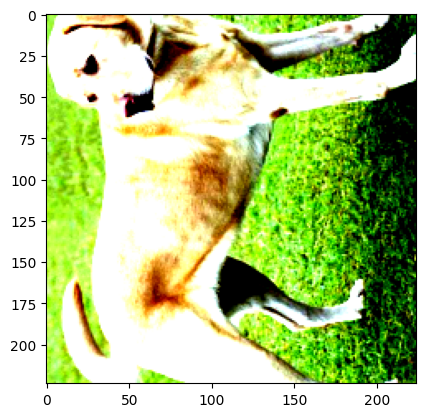

In [233]:
plt.imshow(np.squeeze(image_batch.detach().numpy().T))

In [116]:
blurred.shape

torch.Size([3, 224, 224])